# Experimental Design on Multilayer Preceptron

This notebook performs the analysis and experimental design on the Multilayer Preceptron trained on Fashion-MNIST dataset. Please refer to our writeup for more details.

## Introduction

- Model: a multilayer preceptron that consists of four linear layer with ReLU activation functions. 
![MLP](images/MLP.png)
- Dataset: Fashion MNIST dataset, with 60,000 training samples and 10,000 testing samples. Each sample is a 28 x 28 grayscale image, that is out of the 10 classes: {"T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"}


**Note**: This notebook uses `wandb` to automatically track the model specification, hyperparameters and performance for every run. Before running this notebook, make sure
```
pip install wandb
```
We can then simply edit the `config` dictionary and run the pipeline. All experiments and results will be automatically logged. 

In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

import seaborn as sns
import math

# from tqdm.notebook import tqdm # progress bar

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Preliminaries
We must login to wandb account, in order to record our training on the platform's dashborad. Make sure to install wandb library in our virtual conda environment. 

In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maoli131 (use `wandb login --relogin` to force relogin)


True

## Define Data Loading and Model

In [3]:
# Get training and testing data with config (slice)
def get_data(sls=5, train=True):
    
    full_dataset = datasets.FashionMNIST(
        root="data",
        train=train,
        download=True,
        transform=ToTensor(),
    )
    
    # sls specify the portion of data to use
    sub_dataset = Subset(full_dataset, indices=range(0, int(sls * len(full_dataset)), 1))
    
    return sub_dataset

# Make the dataloader with config (dataset, batch_size
def make_loader(dataset, batch_size, sampler=None):
    if sampler is not None: 
        loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size)
    else:
        loader = DataLoader(dataset=dataset, batch_size=batch_size)
    return loader

In [4]:
# Define model: a simple multilayer preceptron
class MLP(nn.Module):
    def __init__(self, kernels, classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, kernels[0]),
            nn.ReLU(),
            nn.Linear(kernels[0], kernels[1]),
            nn.ReLU(),
            nn.Linear(kernels[1], kernels[2]),
            nn.ReLU(),
            nn.Linear(kernels[2], classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Define Training Logic

`wandb.watch` will log the gradients and the parameters of your model, every `log_freq` steps of training.

In [5]:
def train(model, loader, criterion, optimizer, config):
    
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)
    
    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in range(config.epochs):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 100) == 0:
                train_log(loss, example_ct, epoch)

def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass 
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass 
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

`wandb.log` records the reported metrics to their server. 

In [6]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    #print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

## Define Testing Logic

Once the model is done training, we want to test it: run it against some fresh data from production.

We can save the model's architecture and final parameters to disk. We'll `export` our model in the
[Open Neural Network eXchange (ONNX) format](https://onnx.ai/).

Passing that filename to `wandb.save` ensures that the model parameters are saved to W&B's servers: no more losing track of which `.h5` or `.pb` corresponds to which training runs!

In [7]:
def test(model, test_loader):
    
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader: #TODO
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"images: {100 * correct / total}%")
        
    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")
    
    return correct / total

## Define the experiment and pipeline

### Make

To ensure the values we chose and logged are always the ones that get used
in our model, we use the `wandb.config` copy of your object.

In [8]:
def make(config):
    # Make the data
    train, test = get_data(train=True, sls=config.sls), get_data(train=False, sls=1)
    
    # Divide train set into train and validation
    indices = list(range(len(train)))
    np.random.shuffle(indices)
    split = int(np.floor(0.2 * len(train))) # 20% training is validation
    train_sampler = SubsetRandomSampler(indices[split:])
    valid_sampler = SubsetRandomSampler(indices[:split])
    
    # Create data loader
    train_loader = make_loader(train, sampler=train_sampler, batch_size=config.batch_size)
    valid_loader = make_loader(train, sampler=valid_sampler, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # Make the model
    model = MLP(config.kernels, config.classes).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, valid_loader, test_loader, criterion, optimizer

### Pipeline

The overall pipeline is structured as the following:
1. we first `make` a model, plus associated data and optimizer, then
2. we `train` the model accordingly and finally
3. `test` it to see how training went.

In [9]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="cs294-082-final", config=hyperparameters):
      
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, valid_loader, test_loader, criterion, optimizer = make(config)
        #print(model)

        # and use them to train the model
        train(model, train_loader, criterion, optimizer, config)

        # and test its final performance on train/validation/test data
        tr_acc = test(model, train_loader)
        va_acc = test(model, valid_loader)
        te_acc = test(model, test_loader)
        
        acc = {
            "train": tr_acc,
            "valid": va_acc,
            "test": te_acc
        }
        
        wandb.log(acc)

    return model, acc

### Run the Model 

- Config: Hyperparameters and metadata for our model is stored in a dictionary `config`.
- Pipeline: build, train and analyze the model with pipline

### Model Accuracy vs. Percentage of Training Data Used

We vary the `sls` in `config` to train the model with 10%, 30%, 50%, 70% and 100% of our data. We run training for 80 epochs. 

Accuracy of the model on the 4800 images: 99.79166666666667%
Accuracy of the model on the 1200 images: 84.66666666666667%
Accuracy of the model on the 10000 images: 83.74%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▆▆▃▄▃▃▅▂▃▂▂▂▃▃▂▁▁▁▄▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁
test,▁
train,▁
valid,▁
epoch,79
loss,0.02456
test,0.8374
train,0.99792
valid,0.84667


Accuracy of the model on the 14400 images: 98.19444444444444%
Accuracy of the model on the 3600 images: 87.02777777777777%
Accuracy of the model on the 10000 images: 85.78%


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▄▅▃▄▃▃▅▃▂▂▄▃▂▂▂▃▂▂▂▃▁▂▂▂▁▃▁▁▂▁▁▃▁▁▁▁▂▁
test,▁
train,▁
valid,▁
epoch,79
loss,0.00744
test,0.8578
train,0.98194
valid,0.87028


Accuracy of the model on the 24000 images: 98.38333333333334%
Accuracy of the model on the 6000 images: 88.01666666666667%
Accuracy of the model on the 10000 images: 86.79%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▆▅▄▅▃▃▃▃▄▂▃▃▃▃▃▃▄▁▃▁▁▂▂▃▁▁▂▁▂▂▂▂▁▁▁▃▁▁
test,▁
train,▁
valid,▁
epoch,79
loss,0.00871
test,0.8679
train,0.98383
valid,0.88017


Accuracy of the model on the 33600 images: 99.15178571428571%
Accuracy of the model on the 8400 images: 88.57142857142857%
Accuracy of the model on the 10000 images: 87.75%


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▃▄▅▃▄▃▂▂▄▂▂▂▅▂▂▃▁▂▂▂▂▂▂▂▁▂▃▂▁▂▂▁▁▂▁▁▁
test,▁
train,▁
valid,▁
epoch,79
loss,0.00683
test,0.8775
train,0.99152
valid,0.88571


Accuracy of the model on the 48000 images: 98.82083333333334%
Accuracy of the model on the 12000 images: 89.85%
Accuracy of the model on the 10000 images: 89.07%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▇▄▃▅▄▃▃▂▃▃▂▃▃▂▂▃▂▃▂▂▂▂▁▂▁▂▁▂▂▂▁▁▂▁▂▂▁
test,▁
train,▁
valid,▁
epoch,79
loss,0.01836
test,0.8907
train,0.98821
valid,0.8985


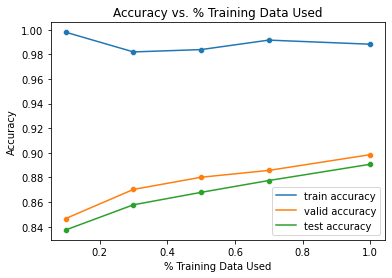

In [10]:
# configurations
config = dict(
    epochs=80,
    classes=10,
    kernels=[256, 128, 128],
    batch_size=64,
    learning_rate=0.001,
    sls = 1,
    dataset="Fashion-MNIST",
    architecture="MLP"
)

# Build, train and analyze the model with the pipeline
portions = [0.1, 0.3, 0.5, 0.7, 1]
train_acc_list = []
valid_acc_list = []
test_acc_list = []
for sls in portions:
    config['sls'] = sls
    model, acc = model_pipeline(config)
    train_acc_list.append(acc['train'])
    valid_acc_list.append(acc['valid'])
    test_acc_list.append(acc['test'])

# Visualize the results
plt.title("Accuracy vs. % Training Data Used")
plt.xlabel("% Training Data Used")
plt.ylabel("Accuracy")
sns.scatterplot(x=portions, y=train_acc_list)
sns.lineplot(x=portions, y=train_acc_list, label="train accuracy")
sns.scatterplot(x=portions, y=valid_acc_list)
sns.lineplot(x=portions, y=valid_acc_list, label="valid accuracy")
sns.scatterplot(x=portions, y=test_acc_list)
sns.lineplot(x=portions, y=test_acc_list, label="test accuracy");

### Model Accuracy vs. Epoches

Train our model at Memory Equivalent Capacity for epoches 1, 10, 20, 30, 50, 80. Can we reach near 100% memorization?

In [22]:
# Assume kernel includes the number of nodes for four layers. 
def compute_mec(kernel, in_features=784):
    layer1 = (in_features + 1) * kernel[0] 
    layer2 = min(kernel[0], (kernel[0] + 1) * kernel[1])
    layer3 = min(kernel[1], (kernel[1] + 1) * kernel[2])
    layer4 = min(kernel[2], (kernel[2] * 1) * 10)
    output = 10 # output layer has 10 bits for 10 nodes 
    return layer1 + layer2 + layer3 + layer4 + output


Training our model at MEC =  201482 



Accuracy of the model on the 48000 images: 83.55208333333333%
Accuracy of the model on the 12000 images: 83.69166666666666%
Accuracy of the model on the 10000 images: 82.39%


epoch,▁▁▁▁▁▁▁
loss,█▇▄▅█▁▆
test,▁
train,▁
valid,▁
epoch,0
loss,0.56321
test,0.8239
train,0.83552
valid,0.83692


Accuracy of the model on the 48000 images: 91.75416666666666%
Accuracy of the model on the 12000 images: 88.84166666666667%
Accuracy of the model on the 10000 images: 88.24%


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,█▇▇▅▄▄▆▅▄▃▃▂▄▂▂▃▃▃▂▂▄▂▃▂▂▂▃▃▃▂▃▄▁▄▂▃▁▂▂▃
test,▁
train,▁
valid,▁
epoch,9
loss,0.26311
test,0.8824
train,0.91754
valid,0.88842


Accuracy of the model on the 48000 images: 93.62291666666667%
Accuracy of the model on the 12000 images: 89.09166666666667%
Accuracy of the model on the 10000 images: 88.33%


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
loss,█▆▅▄▄▅▂▄▄▄▃▂▅▃▁▂▂▃▄▃▂▃▂▄▂▁▃▃▄▁▂▁▃▁▂▃▁▃▂▁
test,▁
train,▁
valid,▁
epoch,19
loss,0.07724
test,0.8833
train,0.93623
valid,0.89092


Accuracy of the model on the 48000 images: 95.775%
Accuracy of the model on the 12000 images: 89.99166666666666%
Accuracy of the model on the 10000 images: 89.0%


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
loss,█▄▅▂▄▃▃▃▃▃▃▂▂▂▂▂▂▃▂▂▁▂▂▁▁▂▂▁▂▁▁▁▂▂▄▁▂▂▁▁
test,▁
train,▁
valid,▁
epoch,29
loss,0.06933
test,0.89
train,0.95775
valid,0.89992


Accuracy of the model on the 48000 images: 97.50208333333333%
Accuracy of the model on the 12000 images: 89.25%
Accuracy of the model on the 10000 images: 88.78%


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▇▆█▄▅▅▅▂▃▃▃▅▃▃▂▃▅▃▃▅▄▄▃▂▁▃▂▁▂▃▂▃▃▂▂▃▂▂▁▁
test,▁
train,▁
valid,▁
epoch,49
loss,0.05316
test,0.8878
train,0.97502
valid,0.8925


Accuracy of the model on the 48000 images: 98.03333333333333%
Accuracy of the model on the 12000 images: 89.40833333333333%
Accuracy of the model on the 10000 images: 88.59%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▆▅▇▄▃▄▃▃▂▄▄▃▄▃▂▂▃▁▂▃▂▂▁▂▂▂▁▁▂▄▃▁▃▁▁▂▄▂
test,▁
train,▁
valid,▁
epoch,79
loss,0.08274
test,0.8859
train,0.98033
valid,0.89408


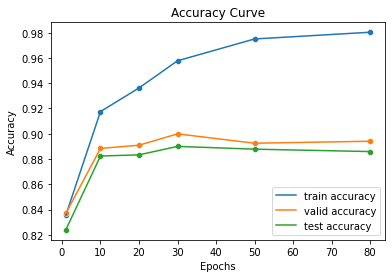

In [29]:
# configurations
config = dict(
    epochs=1,
    classes=10,
    kernels=[256, 128, 128],
    batch_size=64,
    learning_rate=0.001,
    sls = 1,
    dataset="Fashion-MNIST",
    architecture="MLP"
)

# Memory Equivalent Capacity
print("\nTraining our model at MEC = ", compute_mec(config['kernels']), "\n")

# Build, train and analyze the model with the pipeline
epoch_list = [1, 10, 20, 30, 50, 80]
train_acc_list = []
valid_acc_list = []
test_acc_list = []
for e in epoch_list:
    config['epochs'] = e
    model, acc = model_pipeline(config)
    train_acc_list.append(acc['train'])
    valid_acc_list.append(acc['valid'])
    test_acc_list.append(acc['test'])

# Visualize the results
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
sns.scatterplot(x=epoch_list, y=train_acc_list)
sns.lineplot(x=epoch_list, y=train_acc_list, label="train accuracy")
sns.scatterplot(x=epoch_list, y=valid_acc_list)
sns.lineplot(x=epoch_list, y=valid_acc_list, label="valid accuracy")
sns.scatterplot(x=epoch_list, y=test_acc_list)
sns.lineplot(x=epoch_list, y=test_acc_list, label="test accuracy");

### Model Accuracy vs. Model MEC

In this section, we train our machine learner for generalization and plot the capacity / accuracy plot. We vary the `kernels` in `config` to modify the MEC of our model and observe the change in accuracy. The generalization score is also computed. 

Accuracy of the model on the 48000 images: 98.20833333333333%
Accuracy of the model on the 12000 images: 89.08333333333333%
Accuracy of the model on the 10000 images: 88.79%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▆▅▃▆▄█▃▃▃▄▃▂▃▂▃▃▃▄▄▂▂▄▂▃▁▂▃▂▃▂▂▁▂▂▁▃▃▁▁▁
test,▁
train,▁
valid,▁
epoch,79
loss,0.02314
test,0.8879
train,0.98208
valid,0.89083


Accuracy of the model on the 48000 images: 97.04375%
Accuracy of the model on the 12000 images: 88.48333333333333%
Accuracy of the model on the 10000 images: 88.19%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▆▄▃▄▃▂▂▃▃▃▁▃▃▂▂▂▂▂▃▃▂▁▂▁▁▂▂▂▁▂▂▁▁▂▁▁▁▁
test,▁
train,▁
valid,▁
epoch,79
loss,0.04386
test,0.8819
train,0.97044
valid,0.88483


Accuracy of the model on the 48000 images: 96.56458333333333%
Accuracy of the model on the 12000 images: 88.16666666666667%
Accuracy of the model on the 10000 images: 87.81%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▆█▅▇▄█▅▆▅▆▃▄▂▄▄▃▅▃▄▃▄▃▃▃▁▃▃▂▂▃▃▃▂▄▄▁▂▂
test,▁
train,▁
valid,▁
epoch,79
loss,0.07312
test,0.8781
train,0.96565
valid,0.88167


Accuracy of the model on the 48000 images: 93.65833333333333%
Accuracy of the model on the 12000 images: 87.85833333333333%
Accuracy of the model on the 10000 images: 86.57%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▅▄▄█▄▃▃▂▂▃▃▃▂▆▃▁▂▂▂▃▂▁▃▃▂▂▂▃▄▁▃▂▂▁▂▁▂▂▂▁
test,▁
train,▁
valid,▁
epoch,79
loss,0.12173
test,0.8657
train,0.93658
valid,0.87858


Accuracy of the model on the 48000 images: 90.07291666666667%
Accuracy of the model on the 12000 images: 86.38333333333334%
Accuracy of the model on the 10000 images: 85.36%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▇█▇▅▃▆▃▅▆▃▅▃▃▁▆▅▅▂▆▁▄▆▂▃▃▂▅▄▅▂▅▄▄▃▃▂▁▄▄▃
test,▁
train,▁
valid,▁
epoch,79
loss,0.23929
test,0.8536
train,0.90073
valid,0.86383


Accuracy of the model on the 48000 images: 87.32708333333333%
Accuracy of the model on the 12000 images: 84.075%
Accuracy of the model on the 10000 images: 83.81%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▇▅▄▃▄▄▄▆▅▅▄▆▃▆▃▅▄█▅▄▃▃▅▂▂▅▂▄▄▃▂▂▃▁▂▁▄
test,▁
train,▁
valid,▁
epoch,79
loss,0.42826
test,0.8381
train,0.87327
valid,0.84075


Accuracy of the model on the 48000 images: 10.09375%
Accuracy of the model on the 12000 images: 9.625%
Accuracy of the model on the 10000 images: 10.0%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▃▃▃▃▂▄▄▃▃▃▂▃▃▂▃▂▁▂▄▂▃▃▂▂▂▃▃▃▃▃▃▄▃▄▂
test,▁
train,▁
valid,▁
epoch,79
loss,2.30091
test,0.1
train,0.10094
valid,0.09625


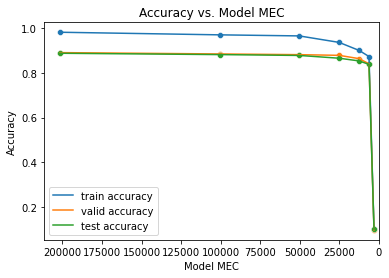

In [26]:
# configurations
config = dict(
    epochs=80,
    classes=10,
    kernels=[256, 128, 128],
    batch_size=64,
    learning_rate=0.001,
    sls = 1,
    dataset="Fashion-MNIST",
    architecture="MLP"
)

# Build, train and analyze the model with the pipeline
k_list = [
    [256, 128, 128],
    [128, 64, 64],
    [64, 32, 32],
    [32, 16, 16],
    [16, 8, 8],
    [8, 4, 4],
    [4, 4, 2]
]
mec_list = [compute_mec(k) for k in k_list] # computes mec for each model
train_acc_list = []
valid_acc_list = []
test_acc_list = []
for k in k_list:
    config['kernels'] = k
    model, acc = model_pipeline(config)
    train_acc_list.append(acc['train'])
    valid_acc_list.append(acc['valid'])
    test_acc_list.append(acc['test'])

# Visualize the results
plt.title("Accuracy vs. Model MEC")
plt.xlabel("Model MEC")
plt.ylabel("Accuracy")
sns.scatterplot(x=mec_list, y=train_acc_list)
sns.lineplot(x=mec_list, y=train_acc_list, label="train accuracy")
sns.scatterplot(x=mec_list, y=valid_acc_list)
sns.lineplot(x=mec_list, y=valid_acc_list, label="valid accuracy")
sns.scatterplot(x=mec_list, y=test_acc_list)
sns.lineplot(x=mec_list, y=test_acc_list, label="test accuracy");
plt.xlim(max(mec_list) + 10000, 0); # invert the x-axis

In [28]:
num_nodes = k_list.copy()
[n.append(10) for n in num_nodes] # include the last output layer
table = pd.DataFrame({
    "# Neurons in Four Layers": num_nodes,
    "Model MEC (bits)": mec_list, 
    "Train Accuracy": train_acc_list, 
    "Validation Accuracy": valid_acc_list,
    "Test Accuracy": test_acc_list
})
table['Generalization'] = table['Train Accuracy'] * 60000 / table['Model MEC (bits)']
table

,# Neurons in Four Layers,Model MEC (bits),Train Accuracy,Validation Accuracy,Test Accuracy,Generalization
0,"[256, 128, 128, 10, 10]",201482,0.982083,0.890833,0.8879,0.292458
1,"[128, 64, 64, 10, 10]",100746,0.970437,0.884833,0.8819,0.577951
2,"[64, 32, 32, 10, 10]",50378,0.965646,0.881667,0.8781,1.150080
3,"[32, 16, 16, 10, 10]",25194,0.936583,0.878583,0.8657,2.230491
4,"[16, 8, 8, 10, 10]",12602,0.900729,0.863833,0.8536,4.288506
5,"[8, 4, 4, 10, 10]",6306,0.873271,0.840750,0.8381,8.308952
6,"[4, 4, 2, 10, 10]",3160,0.100937,0.096250,0.1000,1.916535
